# 一、极化数据压缩

## 1. 无损压缩

极化码对于经典的信源无失真编码问题而言，是最优的。针对这个问题，Arikan提出了与信道极化定理相似的信源极化定理，并给出了一类达到信源熵的码。

注意，Arikan的工作是基于“侧信息”的信源压缩问题，也就是说我们在了解随机变量$X$的概率分布的情况下，还了解某个跟$X$有关的随机变量$Y$，我们知道它们的联合概率分布，也知道在每次实验中$Y$的具体取值是多少。侧信息可以为我们提供一部分信息量，残留的不确定度就是$H(X|Y)$。

在实际场景下一般没有所谓的侧信息，此时只需要认为侧信息$Y$与$X$之间相互独立，下文中出现的相关结论和定理依然成立。

### 1.1 信源极化现象

令$X$是一离散无记忆二进制随机变量，另一随机变量$Y$是关于$X$的“侧信息”（side-information）。我们将随机变量二元组$(X,Y)$复制$N$个相互独立的副本，得到随机序列$(X_{1:N},Y_{1:N})$，其中$N=2^n,n\geq 1$是码长。令$U_{1:N}=X_{1:N}\mathbf{G}_N$是由随机序列$X_{1:N}$经过极化变换后得到的序列，显然它也是随机的。这三类随机变量$U,X,Y$的关系示意图为：

![极化码中的三类随机变量](./figures/universal_diagram.png)

**信源极化定理**：对任意给定的$\delta\in(0,1)$，当$N\to\infty$时，有：

$$\frac{\lvert i\in\{1,\ldots,N\}:H(U_i|Y_{1:N},U_{1:i-1})\in(1-\delta,1]\rvert}{N}\to H(X|Y)$$

以及：

$$\frac{\lvert i\in\{1,\ldots,N\}:H(U_i|Y_{1:N},U_{1:i-1})\in[0,\delta)\rvert}{N}\to 1-H(X|Y)$$

与“极化信道”的概念类似，这里发生极化的也并不是简单的信源，而是所谓的“条件信源”，即已知侧信息$Y_{1:N}$、和前缀随机序列$U_{1:i-1}$的情况下，随机变量$U_i$对应的信源。该定理指出，随着码长的增加，这些信源将要么趋向于均匀分布的信源，要么趋向于几乎完全确定性的信源。

根据条件熵的定义$H(X|Y)=\mathbb{E}_{y}[H(X|Y=y)]$，我们可以准确计算每次实验中的条件概率分布的熵，从而基于Monte-Carlo法对这些条件熵进行估计。以码长$N=1024$、信源熵$H(X)=0.2$为例：

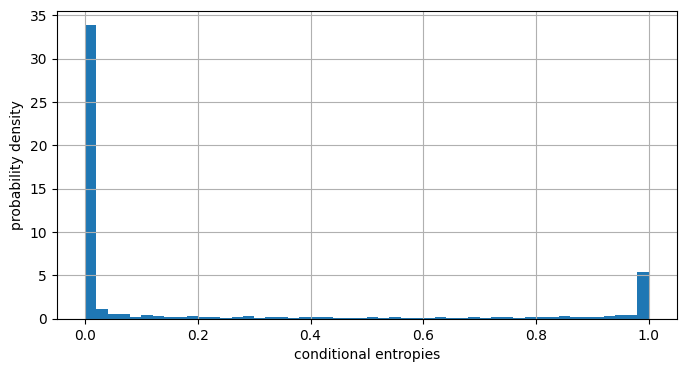

In [1]:
import plcoding
from plcoding.cpp_core.functions import prob_polarize
from plcoding.cpp_core.classics import PolarIterator
import numpy as np
from matplotlib import pyplot as plt
# 初始化系统参数
N = 1024
px = plcoding.p_of(0.2)
px_ = np.tile(px, (N, 1))
# 仿真多次取平均
hu = np.zeros(shape=(N,))
for t in range(1000):
    # 生成数据序列
    x = np.random.choice(a=2, p=px, size=(N,))
    # 计算条件概率分布
    pu, u = prob_polarize(px_, x)
    # 计算条件概率分布的熵
    hu += (-pu * np.log2(pu + 1e-100)).sum(axis=1) / 1000
plt.figure(figsize=(8, 4))
plt.hist(hu, bins=50, density=True)
plt.xlabel("conditional entropies")
plt.ylabel("probability density")
plt.grid(True); plt.show()

### 1.2 信源极化速率

出于相似性，我们可以粗略地说信源极化的速率与信道极化的速率是一致的。具体来讲，首先我们给出两个随机变量$X$和$Y$之间的Bhattacharyya参数：

$$Z(X|Y) \triangleq 2 \sum_y P_Y(y) \sqrt{P_{X|Y}(0|y) \cdot P_{X|Y}(1|y)}$$

该参数与随机变量的条件熵之间的关系为：
1. $Z(X|Y)^2 \leq H(X|Y)$，表示两者同时趋于$1$；
2. $H(X|Y) \leq \log{(1+Z(X|Y))}$，表示两者同时趋于$0$。

**高熵集**：给定码长$N=2^n,n\geq 1$，随机变量$X_N$，它的侧信息$Y_{1:N}$，以及一个码率$R$，如果集合$\mathcal{H}$满足如下条件，则称它是参数$(N,R)$下的高熵集（high-entropy set）：
1. $\mathcal{H} \subset \{1,\ldots,N\}$，表示它是一个关于索引的集合；
2. $|\mathcal{H}| = \lceil NR \rceil$，表示它是按照码率$R$选取的；
3. $\forall i \in \mathcal{H},\forall j \not\in \mathcal{H}, Z(U_i|Y_{1:N},U_{1:i-1}) \geq Z(U_j|Y_{1:N},U_{1:j-1})$，表示它对应了最大的几个Bhattacharyya参数。

**速率定理**：给定一对满足上述描述的信源$(X,Y)$，固定码率$R > H(X|Y)$不变，固定参数$\beta < \frac{1}{2}$不变，当码长$N$足够大时，总存在一个与$(N,R)$对应的高熵集$\mathcal{H}$，满足：

$$\sum_{i\not\in\mathcal{H}}Z(U_i|Y_{1:N},U_{1:i-1})=\mathcal{O}(2^{-N^\beta})$$

我们可以绘制一下这个趋势：

In [2]:
# 指定码长N，估计Z参数
def get_Z(N, H, tt=100):
    px = plcoding.p_of(H)
    px_ = np.tile(px, (N, 1))
    Zu = np.zeros(shape=(N,))
    for t in range(tt):
        x = np.random.choice(a=2, p=px, size=(N,))
        pu, u = prob_polarize(px_, x)
        Zu += np.sqrt(np.prod(pu, axis=1)) / tt
    return Zu
# 指定(N, R)，计算低熵集内的Z参数之和
def sum_Z(N, R, H):
    Zu = get_Z(N, H)
    L = N - int(np.ceil(N * R))
    return np.sum(np.partition(Zu, L - 1)[:L])

In [3]:
# 指定信源熵、编码码率的情况，计算不同码长下低熵集的Z参数之和
ns = np.arange(1, 18)
y1 = np.array([sum_Z(N=(1 << n), R=0.4, H=0.3) for n in ns])

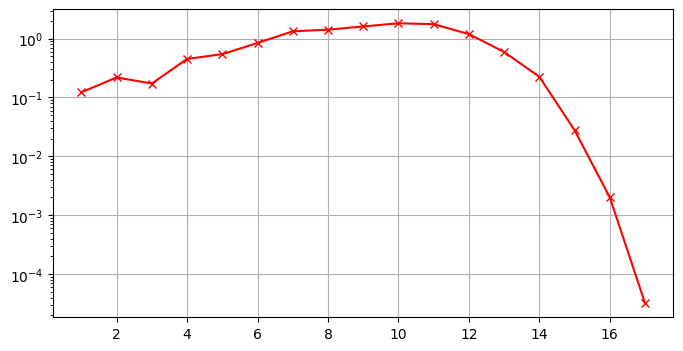

In [4]:
plt.figure(figsize=(8, 4))
plt.semilogy(ns, y1, 'r-x')
plt.grid(); plt.show()

### 1.3 信源极化码

**编码**：设码长$N=2^n,n\geq 1$，在某次实验中各个信源的实现值分别为$x_{1:N}$、$u_{1:N}=x_{1:N}\mathbf{G}_N$以及$y_{1:N}$，那么编码器应当输出由高熵集所指示的子序列$u_{\mathcal{H}}$。

**译码**：译码器在译码开始前已知侧信息$y_{1:N}$，目标是根据编码器的输出序列$u_{\mathcal{H}}$恢复信源序列$x_{1:N}$。为了实现这个任务，首先它将执行SC译码算法对完整序列$u_{1:N}$进行估计：

$$\hat{u}_i \gets \begin{cases}
u_i, &\text{if } i \in \mathcal{H} \\
0, &\text{if } i \not\in \mathcal{H} \text{ and } \frac{\Pr(U_i=0|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1})}{\Pr(U_i=1|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1})} \geq 1 \\
1, &\text{otherwise}
\end{cases}$$

最后对其进行反变换，即可得到估计值$\hat{x}_{1:N} = \hat{u}_{1:N} \mathbf{G}_N^{-1}$。



### 1.4 简单讨论

根据速率定理，在长码长下，信源极化码在SC译码准则下的错误率以大概$\frac{1}{2^{\sqrt{N}}}$的速度下降，最终趋于$0$。这意味着该方案是信源无失真编码问题的一个可行解。但是，在码长有限的情况下，译码错误是有概率发生的。出于这个原因，这种最初级形式的极化码是不适合用到实际场景下进行数据压缩的，因为我们不可能接受一个“有概率恢复失败”的数据压缩技术。极化码达到理论最优，更多地是一种理论上的结论，并且遗憾的是，目前关于其实用化的研究工作很少。

此外，一定要注意关于极化速率的严格表述，不能有任何偏差。在实验中可能会犯的两个错误是：
1. 随着码长$N$增加，不断调整码率$R$接近信源熵，检查相应的译码错误率；
    - 正确做法：只有在保持码率$R$不变的条件下，当码长$N$足够长时，我们才能找到一个错误率足够低的高熵集；
2. 将子序列$u_{\mathcal{H}}$的长度设置为$|\mathcal{H}|=\lceil NH(X|Y) \rceil$；
    - 正确做法：你不应该将码率设置为$R=H(X|Y)$，必须只能令$R>H(X|Y)$。



### 1.5 实用化改进策略

信源极化码达到无失真编码界，更多的只是一种理论上的行为，不便于实际应用。目前在这方面有一些简单的工作，可以概括为：
1. 每次编码完成后，立即测试一下能否成功译码，如果不能，则将$x_{1:N}$随机重排，然后再次编码、测试，直到成功。这种做法可以在稍微损失一点码率（因为要记录重排操作）的情况下，大幅降低译码错误率，整体性能会有所改善；
2. 每次编码完成后，立即测试一下能否成功译码，如果不能，则将发生错误的位置以及相应的符号值记录下来，存储方式就使用简单的比特表示法。这种做法乍一看可能会带来码率损失，但其实可以对冻结集的定义稍加优化，最终将得到更好的性能；
3. 每次编码完成后，立即执行一轮全冻结的SC译码，并记录出错位置，然后找出最小的出错位对应的条件熵，最后将不小于这个熵值的所有比特位全部输出。相当于直接将原方案拓展为了变长版本。

---

## 2. 有损压缩

极化码对限失真信源压缩问题而言，也是最优的。这项工作由Satish Babu Korada和Rüdiger L. Urbanke完成。相比无失真信源压缩而言，这个问题更加复杂，所采用的极化码也是一类奇特的随机码。

### 2.1 限失真信源编码

我们在本小节概括性地列举一下将会用到的基本概念。

**率失真函数**：对于一个给定的离散无记忆信源$X$和一个指定的失真度测量函数$d(\cdot,\cdot)$，率失真函数的定义为：

$$R(D)=\min\limits_{p(\hat{x}|x):\mathbb{E}[d(X|\hat{X})]\leq D}I(X;\hat{X})$$

其中：
1. $X$是信源随机变量，取值于集合$\mathcal{X}$，概率分布已知；而$\hat{X}$则是另一个同样取值于集合$\mathcal{X}$的随机变量，它由$X$通过转移概率矩阵$p(\hat{x}|x)$生成；
2. $\mathbb{E}[d(x,\hat{x})]$是失真度测量函数关于某联合概率分布$p(x,\hat{x})$的期望，该联合概率分布由条件概率分布$p(\hat{x}|x)$所生成；
3. $D \geq 0$是自变量，表示失真度；
4. $I(X;\hat{X})$表示$X$和$\hat{X}$之间的互信息。

通俗地讲，给定任意一个转移概率矩阵$p(\hat{x}|x)$，都可以将$X$映射为另一个随机变量$\hat{X}$，这两个随机变量之间的互信息记作$I(X;\hat{X})$；进一步地，我们还可以计算出此时的平均失真度$\mathbb{E}[d(X|\hat{X})]$。也就是说，每个转移概率矩阵都会有一个对应的互信息和平均失真度。在这个理解的基础上，我们定义率失真函数$R(D)$是所有平均失真度不超过$D$的转移概率矩阵中，拥有最小互信息的互信息值。

求解该函数的过程是一个优化过程，对不同的信源（甚至是连续信源）、不同的失真度测量函数，有不同的率失真函数。一般来讲我们只关注几个比较重要的组合，例如二进制信源与Hamming失真测度、Gaussian信源与平方失真测度等。

接下来我们引入信源编译码器的概念。设信源随机序列的长度为$n$，那么编码器就是一个将信源随机序列映射到$M_n$个码字的函数$f_n:\mathcal{X}^n\mapsto\{1,2\ldots,M_n\}$，译码器则是从码字映射回原空间的函数$g_n:\{1,2,\ldots,M_n\}\mapsto\mathcal{X}^n$，它们的码率为$R_n=\frac{1}{n}\log{M_n}$。我们称映射回的随机变量$\hat{X}\triangleq g_n(f_n(X))$为$X$的重构。

**限失真信源编码定理**：对任意$\epsilon>0$，存在正整数$n$和编译码器$f_n,g_n$，满足：

$$R_n \leq R(D) + \epsilon,\frac{1}{n}\sum_{i=1}^{N}\mathbb{E}[d(X_i,\hat{X}_i)]\leq D+\epsilon$$

**Conversely**：若对某编译码器而言，有：

$$\mathop{\lim\sup}\limits_{n\to\infty}\frac{1}{n}\sum_{i=1}^{N}\mathbb{E}[d(X_i,\hat{X}_i)]\leq D$$

则必有：

$$\mathop{\lim\inf}\limits_{n\to\infty}R_n\geq R(D)$$

上面两个定理共同作用，得到率失真函数可达的最终结论。

### 2.2 极化码回顾

**极化码**：由集合$F\subset\{1,\ldots,N\}$和向量$u_F\in\{0,1\}^{|F|}$定义的极化码$C_N(F,u_F)$，指的是按照如下方式生成的线性码：

$$C_N(F,u_F)=\{x_{1:N}=u_{1:N}\mathbf{G}_N:u_{F^c}\in\{0,1\}^{|F^c|}\}$$

也就是说，码$C_N(F,u_F)$是通过将集合$F$所指示的子序列固定取值为$u_F$，然后令$u_{F^c}$遍历所有可能值所生成的。

**极化码集**：给定集合$F\subset\{1,\ldots,N\}$，极化码集$C_N(F)$指的是如下集合：

$$C_N(F)=\{C_N(F,u_F),\forall u_F\in\{0,1\}^{|F|}\}$$

也就是具有相同冻结集$F$的所有极化码所构成的集合。

> 极化码理论工作的固定范式：分析给定冻结集$F$对应的所有极化码的平均错误率，然后说明冻结向量的取值与性能无关。

### 2.3 核心内容

**方案概览**：考虑使用一个极化码$C_N(F,u_F)$来进行信源编码。冻结集$F$以及相应的冻结向量$u_F$对编码器和译码器而言都是已知的。编码过程是将信源序列$y_{1:N}$映射到码字$x_{1:N}\in C_N(F,u_F)$。由于冻结向量$u_F$是已知的、确定的，因此实际上码字$x_{1:N}$是由非冻结向量$u_{F^c}=(x_{1:N}\mathbf{G}_N^{-1})_{F^c}$唯一确定的，我们可以称其为该码字的“索引”。译码过程是根据这个码字的索引$u_{F^c}$恢复码字的值$x_{1:N}$。由于编译码器对冻结向量$u_F$的值是了解的，因此这个恢复过程就是简单的矩阵运算$x_{1:N}=u_{1:N}\mathbf{G}_N$。不难知道，该编译码策略的码率就是$\frac{|F^c|}{N}$。

> $y_{1:N}$和$x_{1:N}$之间的映射不必一一对应，也不必是确定性的。

**连续消除编码**：令$y_{1:N}$是信源的一次实现，我们使用$\hat{u}_{1:N}$表示如下基于极化码$C_N(F,u_F)$的编码输出结果：
1. 如果$i \in F$，那么令$\hat{u}_i = u_i$；
2. 如果$i \in F^c$，那么计算条件概率$P_N^{(i)}(u) = \Pr(U_i = u | Y_{1:N} = y_{1:N}, U_{1:i-1} = \hat{u}_{1:i-1})$，然后令：

$$\hat{u}_i = \begin{cases}0, &\text{w.p. } P_N^{(i)}(0) \\ 1, &\text{w.p. } P_N^{(i)}(1)\end{cases}$$

上述记号“w.p.”，全称“with the probability of”，指的是“以概率……执行操作”。这意味着，上述过程的输出结果并非确定的，而是随机的。这种策略被称为随机舍入（randomized rounding）。

**极化码的率失真界可达性定理**：设$Y$是一个二进制对称信源，固定一个设计失真率$D\in(0,\frac{1}{2})$，则对任意码率$R>1-h_2(D)$，和任意一个$\beta\in(0,\frac{1}{2})$，都存在码长为$N$、码率$R_N < R$的极化码，在基于随机舍入的连续消除编码算法下，达到失真度$D_N \leq D + \mathcal{O}(2^{-N^\beta})$。

解释：
1. 二进制对称信源，其实就是一个输出比特$0/1$的概率均为$0.5$二进制离散无记忆信源；
2. 设计失真率$D$，极化码的设计参数，后面将基于此确定一个最优的极化码；
3. 参数$\beta$以及相应的$\mathcal{O}(2^{-N^\beta})$都是用于表示极化速率的参数，这意味着这份工作不仅证明了渐进性，还证明了渐进趋势。

**确定冻结集**：考虑设计失真度为$D$，令$W$表示一个比特翻转概率为$D$的二进制对称信道，令$R=R(D)+\delta$其中$\delta>0$是任意给定的值。我们认为信源序列$Y_{1:N}$和编码结果$U_{1:N}$之间通过信道$W$和$\mathbf{G}_N$相连，也即构成下所示关系：  
![极化码经典结构](./figures/universal_diagram.png)  
计算所有的Bhattacharyya参数$Z(W_N^{(i)}),i\in\{1,\ldots,N\}$并将它们按照从大到小排序，然后使用前$\lfloor NR \rfloor$个元素对应的索引构成集合$\mathcal{F}$。

**冻结向量不影响性能**：给定冻结集$F\subset\{1,\ldots,N\}$，上述编译码方案的平均失真度$D_N(F,u_F)$与冻结向量$u_F\in\{0,1\}^{|F|}$的取值无关。

### 2.4 仿真与总结

首先给出论文展示的仿真结果：

![极化码的率失真性能](./figures/lossy_source.png)

这个结果图其实有一些轻微的误导性，看起来似乎随着码长增加，极化码的率失真曲线逐渐贴近了Shannon所规定的率失真界。但如果这样想就会很容易产生误解。实际上，这里的每个点，都对应了一个不同的极化码$C_N(F,u_F)$。换句话说，这个结果图所描述的其实是“极化码这一类码”的能力，而不是“某一个极化码”的能力。

可以简单用代码实现一下。首先考虑码长为$N=1024$、设计失真度为$D=0.11$的极化码$C_N(F,u_F)$，我们使用Monte-Carlo法选取一个合适的冻结集$F$：

In [5]:
# 仿真参数与初始化
N, q = 1024, 2
D, R = 0.11, 0.55
# 选取Z最大的几项为冻结集
Z = get_Z(N, plcoding.h2_of(D))
is_frozen = plcoding.topk_indicate(Z, N - int(np.ceil(N * R)))

然后随机生成一个信源序列$y_{1:N}$，对它进行SC编码、并统计译码后的平均失真度：

In [6]:
# 随机生成信源数据
y = np.random.choice(a=q, p=np.array([0.5, 0.5]), size=(N,))

In [7]:
# 初始化SC迭代器
pIter = PolarIterator(N, q)
px = np.empty(shape=(N, q))
px[np.arange(N), y] = 1 - D
px[np.arange(N), 1 - y] = D
pIter.set_priors(px)
pIter.reset()

In [8]:
# SC编码
u_hat = np.empty_like(u)
for i in range(N):
    prob = pIter.get_prob(i)
    if is_frozen[i]:
        symbol = 0
    else:
        symbol = np.random.choice(a=q, p=prob)
    u_hat[i] = symbol
    pIter.set_value(i, symbol)

In [9]:
# 简单译码
bitrev = plcoding.bitrev_perm(N)
y_hat = plcoding.basic_encode(u_hat)[bitrev]
# 统计失真度
print(f"设计失真度{D:.2f}，码率为{R}时的实际失真度为{(y != y_hat).mean():.4f}")

设计失真度0.11，码率为0.55时的实际失真度为0.1162


注意上述所描述的过程与经典的极化码编译码方案存在极其显著的区别。传统的编码方案，一般是将原序列$y_{1:N}$通过极化变换$\mathbf{G}_N$得到变换序列$u_{1:N}$，然后输出其特定的一部分如$u_{\mathcal{H}}$，这个过程是确定的、线性的。

而在有损数据压缩方案中，所采用的编码方案是将原序列$y_{1:N}$的带噪声的先验概率分布$P_Y$输入SC译码器的顶层，然后运行SC迭代译码算法，将特定的一部分$u_F$强制置$0$、剩余部分$u_{F^c}$通过这个译码过程随机地生成。最后输出的结果是随机生成的$u_{F^c}$。某种程度上，这可以理解为是一种“带不确定性的极化软变换”，最终输出的是从不确定的变换结果中随机挑出的一个。

> 实际上使用最大概率rounding替换randomized rounding，也可以达到率失真界，但不方便理论分析所以在文中没有被采用。

基于上面这份代码可以进行各种实验，例如固定码长$N$、固定设计失真度$D$，对不同的码率$R$可以得到不同的极化码$C_N(F,u_F)$。考虑到它们对应了相同的$N$个Bhattacharyya参数，不同极化码之间的区别就是简单的调整码率$R$，具有明显的共性。不妨将这些极化码视作同一类“衍生极化码”。我们可以绘制“D-失真度衍生极化码”的率失真函数。在不同的设计失真度下，它们的率失真函数各不相同，从而形成一个包络线，如图所示：

![不同方案的包络](./figures/rate_distortion.png)

可以发现，所谓的“D-失真度衍生极化码”并不能达到率失真函数界。若使用时的码率$R$比设计失真度$D$对应码率$R(D)$小太多，输出的信息量太少，将会导致失真度陡增；若使用时的码率$R$比设计失真度$D$对应码率$R(D)$大，则额外输出的比特并不能改善失真度，而是会趋近于设计失真度$D$。